# Recurrent neural networks (RNN)

In [2]:
#spacy works for python 3.8.10
import spacy
#!python3.8 -m spacy download en_core_web_sm

#word2vec
from gensim.models import Word2Vec
from gensim import downloader

import string
import numpy as np
import pandas as pd

from gensim.models import Word2Vec
from gensim import downloader

#modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

#saving model
import pickle

2023-03-28 15:28:00.155878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Functions and global vars definition

In [3]:
DEVELOPING = True
MAX_LENGTH = 80

In [21]:
nlp = spacy.load("en_core_web_sm")#english tokenizer, tagger, parser and NER
def split_sentences(text):
    aux_sentence = nlp(text)
    return [str(token.lemma_).lower() for token in aux_sentence if not (token.is_stop or \
                                                                token.is_punct or \
                                                                len(token)<3)]

def encoding_data(data_train,data_test,max_length):
    """This function creates the tokenizer, fits it to the data, tokenizes and padds train and test dataframes,
    saves the fitted tokenizer into a file, and finally returns train and test dataframes with text encoded as well as 
    the labels one hot encoded and the word_index dictionary"""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data_train["preprocessed_content"])

    # word_index is a dictionary contains indeces for the words like {'for': 8, 'is': 9, 'me': 10, ...}
    word_index = tokenizer.word_index

    # train_sequences is vectors where each vector represents a sentence
    train_sequences = tokenizer.texts_to_sequences(data_train["preprocessed_content"])
    test_sequences = tokenizer.texts_to_sequences(data_test["preprocessed_content"])

    train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding="pre")
    test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding="pre")

    # Convert our labels into one-hot encoded
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(np.array(data_train["label"]).reshape(-1, 1))

    train_labels = onehot_encoder.transform(np.array(data_train["label"]).reshape(-1, 1))
    test_labels = onehot_encoder.transform(np.array(data_test["label"]).reshape(-1, 1))


    # saving
    with open('data/tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


    return train_sequences, test_sequences, train_labels, test_labels, word_index

def embeddingWights(w2v, word_index, max_num_words=500000):
  
  all_embs = np.stack(w2v.wv.vectors)
  emb_mean,emb_std = all_embs.mean(), all_embs.std()

  num_words = min(max_num_words, len(word_index))+1

  embedding_dim=len(w2v.wv['software'])

  embedding_wights = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

  for word, i in word_index.items():
    if i >= max_num_words:
        break

    if word in w2v.wv:
        embedding_vector = w2v.wv[word]
        embedding_wights[i] = embedding_vector
    
  return embedding_wights, num_words

def build_RNN_model(input_size, num_words, output_dim, embedding_wights):

    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=output_dim, trainable=True, input_length=input_size, weights=[embedding_wights]))
    model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.4))
    model.add(LSTM(32, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(14, activation='softmax'))
    model.compile(loss ='categorical_crossentropy', optimizer = "adam", metrics = ["accuracy","F1"])


    return model


In [5]:
data_train = pd.read_csv("clean_df_train.csv")
data_test = pd.read_csv("clean_df_test.csv")

In [6]:
#subsampling for developing faster
if DEVELOPING:
    data_train = data_train.groupby('label').apply(lambda x: x.sample(frac=0.03)).reset_index(drop=True)
    data_test = data_test.groupby('label').apply(lambda x: x.sample(frac=0.03)).reset_index(drop=True)

## preprocessing

### Analyzing length of each sentence

With a length of input of 80 words we are only not completely getting approximatelly a 5% of the data (train and test)

In [7]:
data_train["words_count"] = data_train.apply(lambda row: len(row["content"].split()), axis = 1)
data_test["words_count"] = data_test.apply(lambda row: len(row["content"].split()), axis = 1)

In [8]:
data_train["words_count"].describe()

count    11573.000000
mean        45.155966
std         24.755010
min          2.000000
25%         24.000000
50%         44.000000
75%         65.000000
max       1175.000000
Name: words_count, dtype: float64

In [9]:
data_test["words_count"].describe()

count    1443.000000
mean       45.778933
std        23.077126
min         6.000000
25%        24.000000
50%        44.000000
75%        67.000000
max       179.000000
Name: words_count, dtype: float64

In [10]:
"""#parallelizing (Not sure it works correctly. Maybe mac hardware is not good for this)
import dask.dataframe as dd
from dask.multiprocessing import get

ddata = dd.from_pandas(data_train, npartitions=30)

#data_train[:1000].apply(lambda row: split_sentences(row["content"]), axis = 1)
ddata.map_partitions(lambda df: df.apply((lambda row: split_sentences(row["content"])), axis=1)).compute(scheduler="threads")"""

0        [ware, label, himeyasoft, inc., confuse, distr...
1        [octapharma, large, privately, own, human, pro...
2        [knoll, aircraft, company, american, aircraft,...
3        [middletown, area, transit, popularly, know, m...
4        [fabrap, finch, alexander, barnes, rothschild,...
                               ...                        
11568    [journal, gazette, morning, newspaper, fort, w...
11569    [scandia, academic, journal, history, publish,...
11570    [central, european, journal, mathematics, peer...
11571    [grey, japanese, science, fiction, manga, crea...
11572    [kindly, ones, french, les, bienveillantes, hi...
Length: 11573, dtype: object

In [11]:
data_train["preprocessed_content"] = data_train.apply(lambda row: split_sentences(row["content"]), axis = 1)
data_test["preprocessed_content"] = data_test.apply(lambda row: split_sentences(row["content"]), axis = 1)

In [12]:
data_train.head()

,label,title,content,words_count,preprocessed_content
0,0.0,C's Ware,C's Ware is a label of HimeyaSoft Inc. (not t...,77,"[ware, label, himeyasoft, inc., confuse, distr..."
1,0.0,Octapharma,Octapharma AG is the largest privately owned ...,68,"[octapharma, large, privately, own, human, pro..."
2,0.0,Knoll Aircraft Company,Knoll Aircraft Company was an American aircra...,12,"[knoll, aircraft, company, american, aircraft,..."
3,0.0,Middletown Area Transit,Middletown Area Transit popularly known as MA...,73,"[middletown, area, transit, popularly, know, m..."
4,0.0,FABRAP,FABRAP or Finch Alexander Barnes Rothschild a...,32,"[fabrap, finch, alexander, barnes, rothschild,..."


In [13]:
data_test.head()

,label,title,content,words_count,preprocessed_content
0,0,SemBioSys Genetics,SemBioSys Genetics Inc. was a development sta...,46,"[sembiosys, genetics, inc., development, stage..."
1,0,Element Six,Element Six (formerly De Beers Industrial Dia...,57,"[element, beers, industrial, diamond, company,..."
2,0,NBTY,NBTY Inc. formerly known as Nature's Bounty I...,56,"[nbty, inc., know, nature, bounty, inc., ameri..."
3,0,Pinkberry,Pinkberry is a franchise of upscale frozen de...,65,"[pinkberry, franchise, upscale, frozen, desser..."
4,0,Lam Research,Lam Research Corporation is an American corpo...,27,"[lam, research, corporation, american, corpora..."


### Saving preprocessed dataframes to avoid repeating preprocessing

In [ ]:
data_train.to_csv('preprocessed_df_train.csv', index=False)
data_test.to_csv('preprocessed_df_test.csv', index=False)

## Tokenizer

In [14]:
train_sequences, test_sequences, train_labels, test_labels, word_index = encoding_data(data_train, data_test, MAX_LENGTH)

#Saving all information so we dont need to process them again
with open("data/train_sequences.pickle","wb") as file:
    pickle.dump(train_sequences,file)
with open("data/test_sequences.pickle","wb") as file:
    pickle.dump(test_sequences,file)
with open("data/train_labels.pickle","wb") as file:
    pickle.dump(train_labels,file)
with open("data/test_labels.pickle","wb") as file:
    pickle.dump(test_labels,file)
with open("data/word_index.pickle","wb") as file:
    pickle.dump(word_index,file)

In [15]:
# loading
with open('tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)
with open("data/train_sequences.pickle","rb") as file:
    train_sequences = pickle.load(file)
with open("data/train_sequences.pickle","rb") as file:
    test_sequences = pickle.load(file)
with open("data/train_labels.pickle","rb") as file:
    train_labels = pickle.load(file)
with open("data/test_labels.pickle","rb") as file:
    test_labels = pickle.load(file)
with open("data/word_index.pickle","rb") as file:
    word_index = pickle.load(file)

# Defnining word embedding

### Creating our own word embedding with Word2vec

+ min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
+ window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
+ size = int - Dimensionality of the feature vectors. - (50, 300)
+ sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
+ alpha = float - The initial learning rate - (0.01, 0.05)
min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
+ negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
+ workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [16]:
#total words in our vocabulary
len(word_index.keys())

43870

In [17]:
w2v_model = Word2Vec(sentences=list(data_train["preprocessed_content"]),
                     min_count=3,
                     window=10,
                     vector_size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5)

In [18]:
#total words in our word embedding ignoring words that appear less than 3 times
len(w2v_model.wv)

11934

In [19]:
#testing similarities
word = 'software'
print(f"3 words similar to **{word}**")
words = w2v_model.wv.most_similar(word, topn=3)
for word in words:
  print(word)

3 words similar to **software**
('son', 0.9998385906219482)
('take', 0.9998255372047424)
('call', 0.9998217225074768)


In [22]:
embedding_wights, num_words = embeddingWights(w2v_model, word_index, max_num_words=500000)

In [23]:
#testing the word embedding by comparing the weights of the final 
#embedding_wights and w2v_model.wv vector for the word "software"

(embedding_wights[word_index["software"],:].reshape([100,1])-w2v_model.wv["software"].reshape([100,1])).sum()

0.0

# Training

### Data separation

In [24]:
train_data, val_data, train_labels, val_labels = train_test_split(train_sequences, 
                                                                  train_labels,
                                                                  test_size = 0.2)
test_data = test_sequences
test_labels = test_labels

In [26]:
RNN_model = build_RNN_model(MAX_LENGTH, num_words, 100, embedding_wights)

stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode = "min")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience = 5, mode = "min", verbose = 1, factor = 0.1, min_delta=0.001, min_lr = 0.00001)

history = RNN_model.fit(train_data, train_labels, epochs = 5,
          batch_size = 48, shuffle=True,
          validation_data=[val_data, val_labels],
          callbacks = [stopping, reduce_lr]
          )

Epoch 1/5
193/193 [==============================] - 171s 831ms/step - loss: 2.6266 - accuracy: 0.1032 - val_loss: 2.5628 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 2/5
193/193 [==============================] - 170s 883ms/step - loss: 2.4886 - accuracy: 0.1404 - val_loss: 2.2567 - val_accuracy: 0.1603 - lr: 0.0010
Epoch 3/5
193/193 [==============================] - 158s 815ms/step - loss: 2.2110 - accuracy: 0.1872 - val_loss: 2.0001 - val_accuracy: 0.2220 - lr: 0.0010
Epoch 4/5
193/193 [==============================] - 157s 814ms/step - loss: 1.9174 - accuracy: 0.2471 - val_loss: 1.8049 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 5/5
193/193 [==============================] - 164s 850ms/step - loss: 1.7148 - accuracy: 0.3006 - val_loss: 1.7050 - val_accuracy: 0.3145 - lr: 0.0010


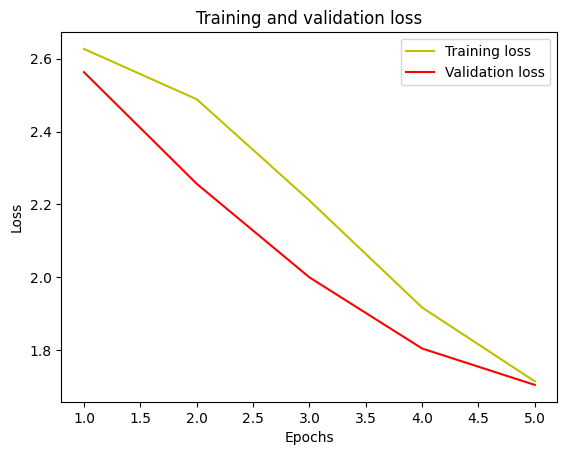

In [29]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()